In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

2024-05-31 20:13:20.685785: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 20:13:20.685870: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 20:13:20.685896: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 20:13:20.693914: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('dataset/windows/windowed_1.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810112 entries, 0 to 810111
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   time    810112 non-null  int64 
 1   A_F     810112 non-null  int64 
 2   A_V     810112 non-null  int64 
 3   A_L     810112 non-null  int64 
 4   L_F     810112 non-null  int64 
 5   L_V     810112 non-null  int64 
 6   L_L     810112 non-null  int64 
 7   T_F     810112 non-null  int64 
 8   T_V     810112 non-null  int64 
 9   T_L     810112 non-null  int64 
 10  Action  810112 non-null  int64 
 11  name    810112 non-null  object
dtypes: int64(11), object(1)
memory usage: 74.2+ MB


In [4]:
# 'name' 열에서 2, 3번째 숫자를 추출하여 새로운 열 'user_number' 생성
df['user_number'] = df['name'].str[1:3]

# 'user_number' 열을 int형으로 변환
df['user_number'] = df['user_number'].astype(int)

# 기존 'name' 열 삭제
df.drop(columns=['name'], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810112 entries, 0 to 810111
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   time         810112 non-null  int64
 1   A_F          810112 non-null  int64
 2   A_V          810112 non-null  int64
 3   A_L          810112 non-null  int64
 4   L_F          810112 non-null  int64
 5   L_V          810112 non-null  int64
 6   L_L          810112 non-null  int64
 7   T_F          810112 non-null  int64
 8   T_V          810112 non-null  int64
 9   T_L          810112 non-null  int64
 10  Action       810112 non-null  int64
 11  user_number  810112 non-null  int64
dtypes: int64(12)
memory usage: 74.2 MB


In [6]:
df.shape

(810112, 12)

In [7]:
df['Action'].value_counts()

0    691456
1    103488
2     15168
Name: Action, dtype: int64

In [8]:
# status 열에서 값이 0인 행 제거
df = df[df['Action'] != 0]

# status 열에서 값이 1인 행을 0으로, 값이 2인 행을 1로 바꾸기
df['Action'] = df['Action'].replace({1: 0, 2: 1})

In [9]:
df['Action'].value_counts()

0    103488
1     15168
Name: Action, dtype: int64

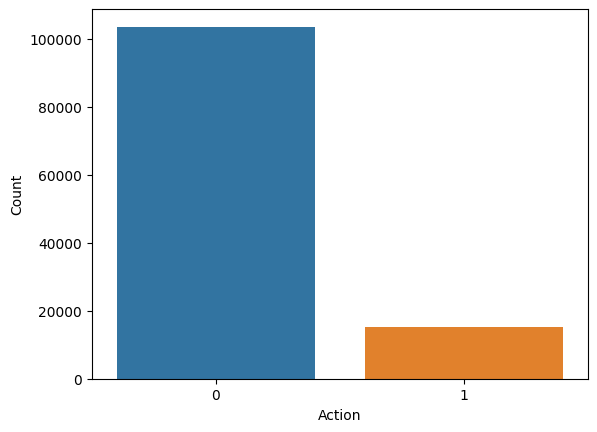

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and '0' is the column name
# Ensure the column is of categorical dtype
df['Action'] = df['Action'].astype('category')

# Now plot
sns.countplot(data=df, x="Action")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

In [11]:
def split_sequence(X, y, n_steps):
    X_seq, y_seq = list(), list()
    for i in range(len(X) - n_steps + 1):
        end_ix = i + n_steps
        seq_x = X[i:end_ix]
        seq_y = y[end_ix-1]
        X_seq.append(seq_x)
        y_seq.append(seq_y)
    return np.array(X_seq), np.array(y_seq)

In [12]:
X = df.drop(columns=['Action']).to_numpy()
y = df['Action'].to_numpy()

In [13]:
n_steps = 3

In [14]:
X, y = split_sequence(X, y, n_steps)

In [15]:
Y = to_categorical(y)
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [16]:
X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = y)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size = 0.2, random_state = 0, stratify = y_train)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((75938, 3, 11), (23731, 3, 11), (75938, 2), (23731, 2))

In [19]:
n_features, n_outputs = X_train.shape[1], y_train.shape[1]

In [20]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            71680     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             24640     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 2)                 1

In [21]:
print(f"X_train type: {type(X_train)}")
print(f"y_train type: {type(y_train)}")
print(f"X_val type: {type(X_val)}")
print(f"y_val type: {type(y_val)}")

X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
X_val type: <class 'numpy.ndarray'>
y_val type: <class 'numpy.ndarray'>


In [22]:
# 데이터 타입 확인
print("Checking data types...")
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")
print(f"X_val dtype: {X_val.dtype}")
print(f"y_val dtype: {y_val.dtype}")

Checking data types...
X_train dtype: int64
y_train dtype: float32
X_val dtype: int64
y_val dtype: float32


In [23]:
epochs, batch_size = 50, 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), shuffle=True)

Epoch 1/50
1187/1187 [==============================] - 9s 6ms/step - loss: 0.3931 - accuracy: 0.8712 - val_loss: 0.4092 - val_accuracy: 0.8722
Epoch 2/50
1187/1187 [==============================] - 7s 6ms/step - loss: 0.3849 - accuracy: 0.8722 - val_loss: 0.3829 - val_accuracy: 0.8722
Epoch 3/50
1187/1187 [==============================] - 7s 6ms/step - loss: 0.3830 - accuracy: 0.8722 - val_loss: 0.3825 - val_accuracy: 0.8722
Epoch 4/50
1187/1187 [==============================] - 7s 6ms/step - loss: 0.3826 - accuracy: 0.8722 - val_loss: 0.3823 - val_accuracy: 0.8722
Epoch 5/50
1187/1187 [==============================] - 7s 6ms/step - loss: 0.3825 - accuracy: 0.8722 - val_loss: 0.3824 - val_accuracy: 0.8722
Epoch 6/50
1187/1187 [==============================] - 7s 6ms/step - loss: 0.3825 - accuracy: 0.8722 - val_loss: 0.3823 - val_accuracy: 0.8722
Epoch 7/50
1187/1187 [==============================] - 7s 6ms/step - loss: 0.3824 - accuracy: 0.8722 - val_loss: 0.3823 - val_accuracy:

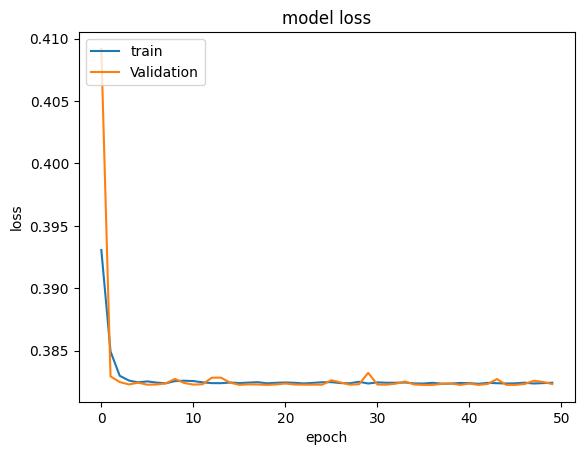

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

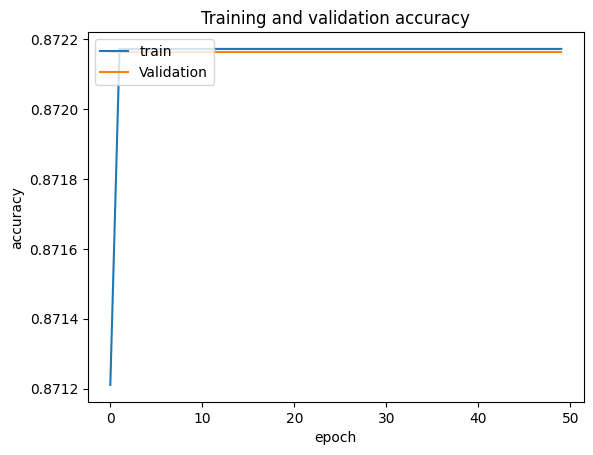

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

742/742 [==============================] - 1s 1ms/step
f1_score =  0.8125909711198092
0.8721503518604358
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     20697
           1       0.00      0.00      0.00      3034

    accuracy                           0.87     23731
   macro avg       0.44      0.50      0.47     23731
weighted avg       0.76      0.87      0.81     23731



/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

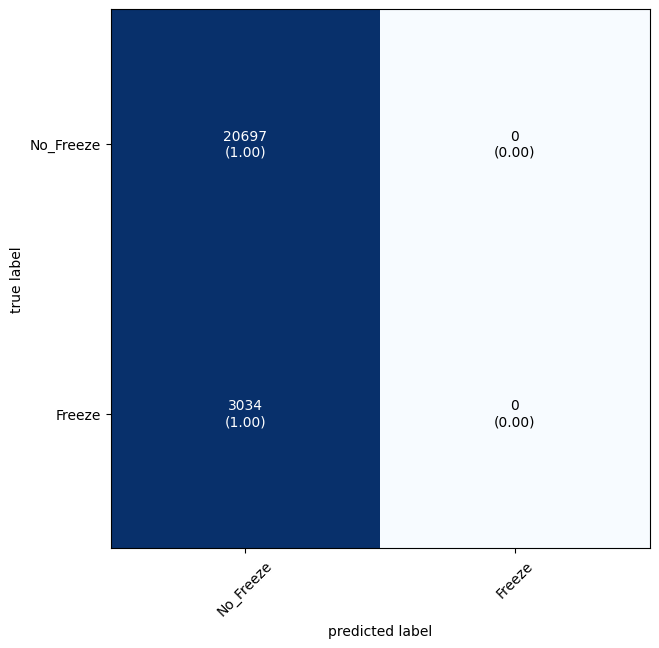

In [26]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np

# 모델 예측
predy = model.predict(X_test)
predy = np.argmax(predy, axis=-1)
y_true = np.argmax(y_test, axis=-1)

LABELS = ['No_Freeze', 'Freeze']
cm = confusion_matrix(y_true, predy)

# 결과 출력
print('f1_score = ', f1_score(y_true, predy, average='weighted'))
print(accuracy_score(y_true, predy))
print(classification_report(y_true, predy))

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7, 7))

### SMOTE() 오버 샘플링

In [27]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop('Action', axis=1), df['Action'])

In [28]:
df = pd.concat([pd.DataFrame(X_resampled, columns=df.drop('Action', axis=1).columns),
                         pd.DataFrame({'Action': y_resampled})], axis=1)

In [29]:
print(df['Action'].value_counts())

0    103488
1    103488
Name: Action, dtype: int64


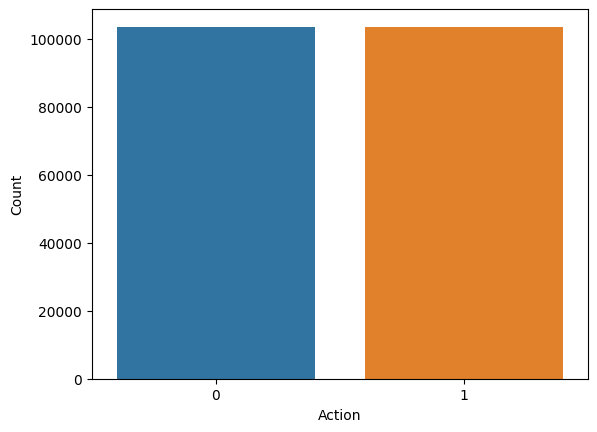

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and '0' is the column name
# Ensure the column is of categorical dtype
df['Action'] = df['Action'].astype('category')

# Now plot
sns.countplot(data=df, x="Action")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

In [31]:
X = df.drop(columns=['Action']).to_numpy()
y = df['Action'].to_numpy()

In [32]:
X, y = split_sequence(X, y, n_steps)

In [33]:
Y = to_categorical(y)
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [34]:
X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = y)

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size = 0.2, random_state = 0, stratify = y_train)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((132463, 3, 11), (41395, 3, 11), (132463, 2), (41395, 2))

In [37]:
n_features, n_outputs = X_train.shape[1], y_train.shape[1]

In [38]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 3, 128)            71680     
                                                                 
 dropout_2 (Dropout)         (None, 3, 128)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             24640     
                                                                 
 dropout_3 (Dropout)         (None, 1, 64)             0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 2)                

In [39]:
epochs, batch_size = 50, 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), shuffle=True)

Epoch 1/50
2070/2070 [==============================] - 14s 6ms/step - loss: 0.6947 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
2070/2070 [==============================] - 12s 6ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/50
2070/2070 [==============================] - 12s 6ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
2070/2070 [==============================] - 12s 6ms/step - loss: 0.6933 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/50
2070/2070 [==============================] - 12s 6ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/50
2070/2070 [==============================] - 12s 6ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/50
2070/2070 [==============================] - 12s 6ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_ac

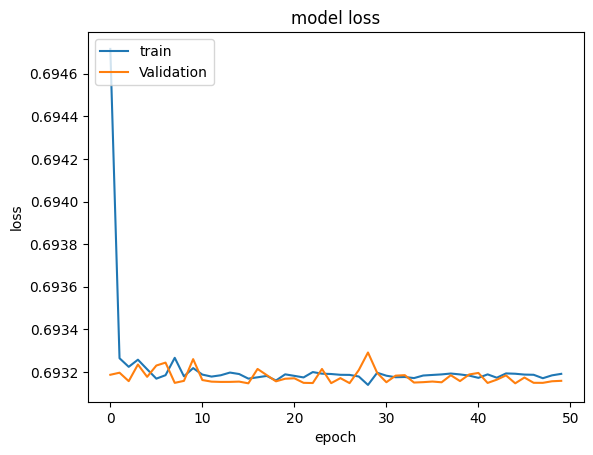

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

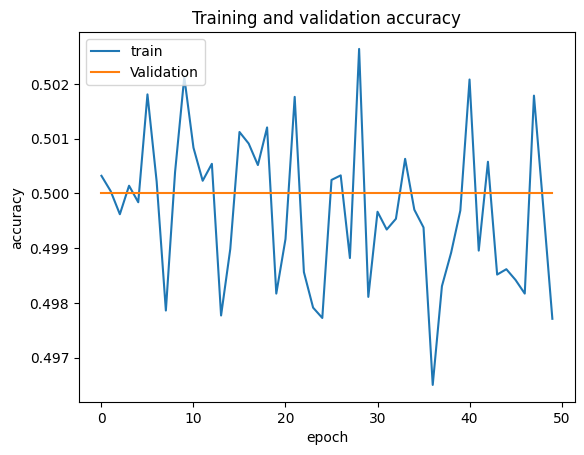

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

1294/1294 [==============================] - 2s 1ms/step
f1_score =  0.33334675425698146
0.5000120787534726
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20697
           1       0.50      1.00      0.67     20698

    accuracy                           0.50     41395
   macro avg       0.25      0.50      0.33     41395
weighted avg       0.25      0.50      0.33     41395



/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

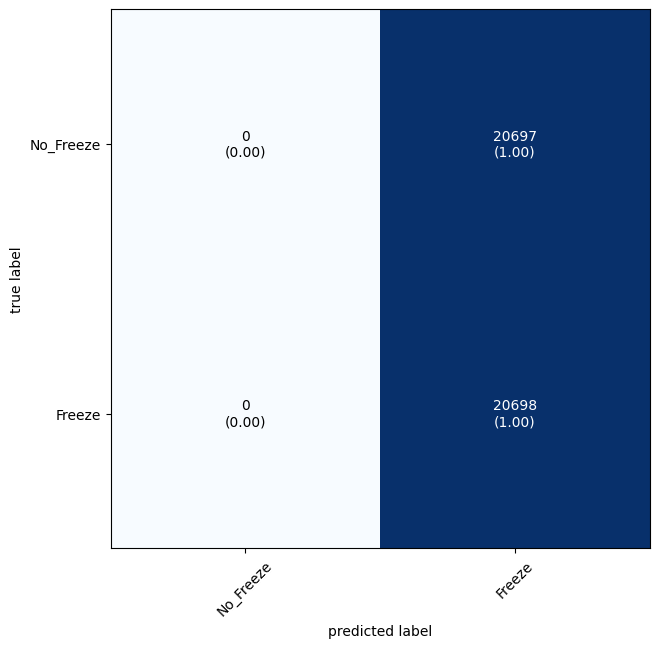

In [42]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np

# 모델 예측
predy = model.predict(X_test)
predy = np.argmax(predy, axis=-1)
y_true = np.argmax(y_test, axis=-1)

LABELS = ['No_Freeze', 'Freeze']
cm = confusion_matrix(y_true, predy)

# 결과 출력
print('f1_score = ', f1_score(y_true, predy, average='weighted'))
print(accuracy_score(y_true, predy))
print(classification_report(y_true, predy))

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7, 7))